## Initial settings

In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = f"{7}"

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import joblib

import sys
sys.path.append("..")
import tools as t


from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA

2024-01-16 14:31:54.304330: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [3]:
from tensorflow import keras
import tensorflow as tf

In [4]:
root_path = "/home/dg321/gitTest/PRI/irp/Ventilation/24-01"

## Load data

In [5]:
rawdata = pd.read_csv(root_path + "/AHU Data 20230410.csv")

In [6]:
print(rawdata.shape)
print(rawdata.columns)
print(rawdata.head())

(863, 11)
Index(['Timestamp', 'AI5_AHUintakeAirHumiditySensor (%RH)',
       'AI6_AHUSupplyAirHumiditySensor', 'AI7_ExternalOutsideHumiditySensor',
       'NewGrowRmAvHum', 'NewGrowRmAvTemp', 'UI4_AHUfreshAirTempSensor',
       'UI5_AHUsupplyAirTempSensor', 'UI6_AHUextractAirTempSensor',
       'XXAHUCALCHUMIDITYSETPOINTXX', 'XXAHUCALCTEMPERATURESETPOINTXX'],
      dtype='object')
                   Timestamp  AI5_AHUintakeAirHumiditySensor (%RH)  \
0  01-Apr-23 12:00:00 AM BST                                 76.79   
1  01-Apr-23 12:15:00 AM BST                                 76.12   
2  01-Apr-23 12:30:00 AM BST                                 74.55   
3  01-Apr-23 12:45:00 AM BST                                 75.55   
4   01-Apr-23 1:00:00 AM BST                                 73.18   

   AI6_AHUSupplyAirHumiditySensor  AI7_ExternalOutsideHumiditySensor  \
0                           68.03                              85.48   
1                           67.24                  

In [7]:
print(rawdata["Timestamp"][0])
print(rawdata["Timestamp"][862])

01-Apr-23 12:00:00 AM BST
09-Apr-23 11:45:00 PM BST


In [8]:
rawdata['Timestamp'] = pd.to_datetime(rawdata['Timestamp'])

In [9]:
# Convert timestamp to seconds
timestamp_seconds = (rawdata['Timestamp'] - rawdata['Timestamp'].min()).dt.total_seconds()

# Calculate time sin and time cos
time_sin = np.sin(2 * np.pi * timestamp_seconds / (24 * 60 * 60))
time_cos = np.cos(2 * np.pi * timestamp_seconds / (24 * 60 * 60))

rawdata.insert(1, 'time_sin', time_sin)
rawdata.insert(2, 'time_cos', time_cos)


In [10]:
print(rawdata.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 863 entries, 0 to 862
Data columns (total 13 columns):
 #   Column                                Non-Null Count  Dtype                               
---  ------                                --------------  -----                               
 0   Timestamp                             863 non-null    datetime64[ns, pytz.FixedOffset(60)]
 1   time_sin                              863 non-null    float64                             
 2   time_cos                              863 non-null    float64                             
 3   AI5_AHUintakeAirHumiditySensor (%RH)  863 non-null    float64                             
 4   AI6_AHUSupplyAirHumiditySensor        863 non-null    float64                             
 5   AI7_ExternalOutsideHumiditySensor     863 non-null    float64                             
 6   NewGrowRmAvHum                        863 non-null    float64                             
 7   NewGrowRmAvTemp           

In [11]:
column_names_list = rawdata.columns.tolist()

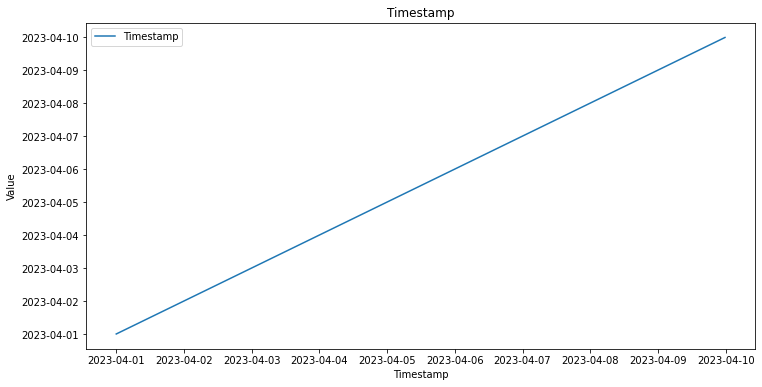

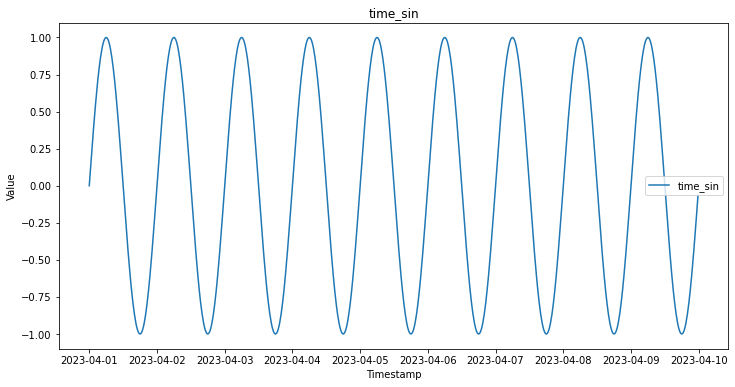

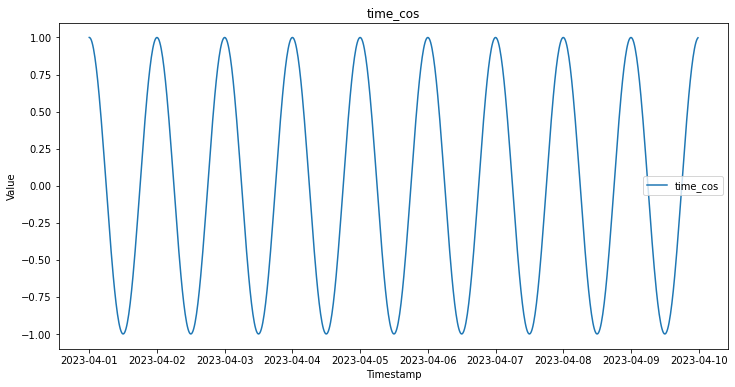

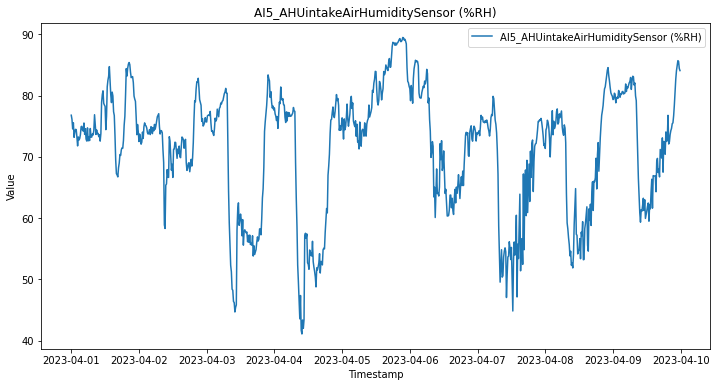

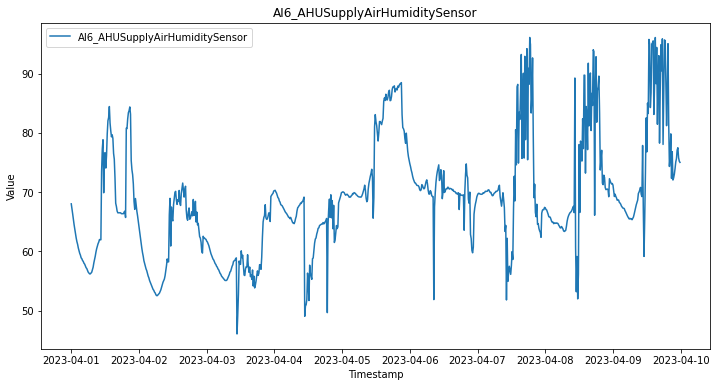

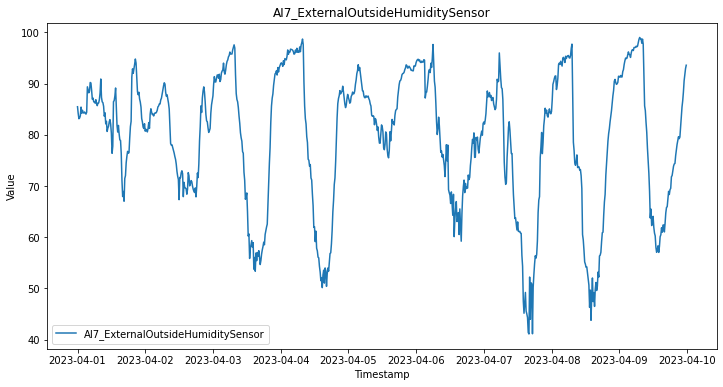

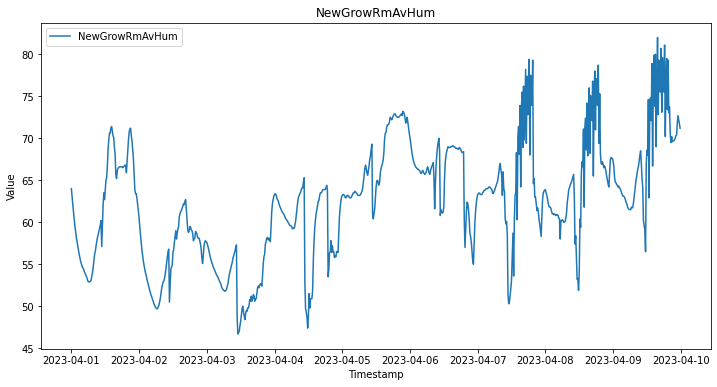

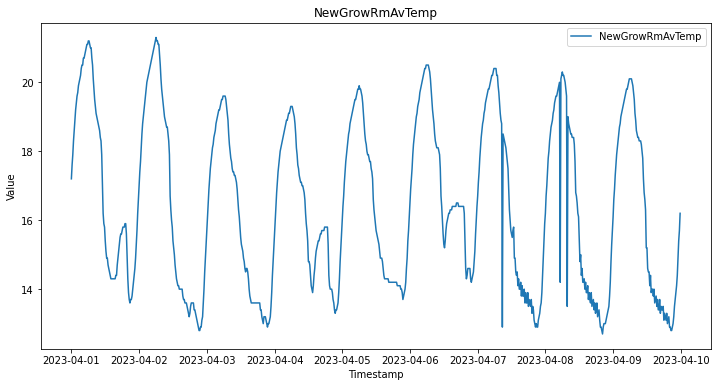

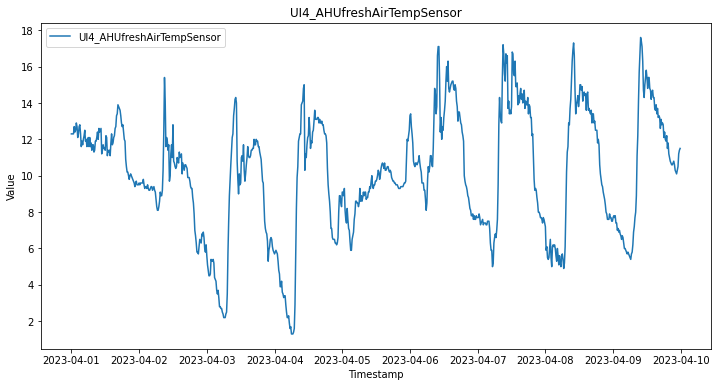

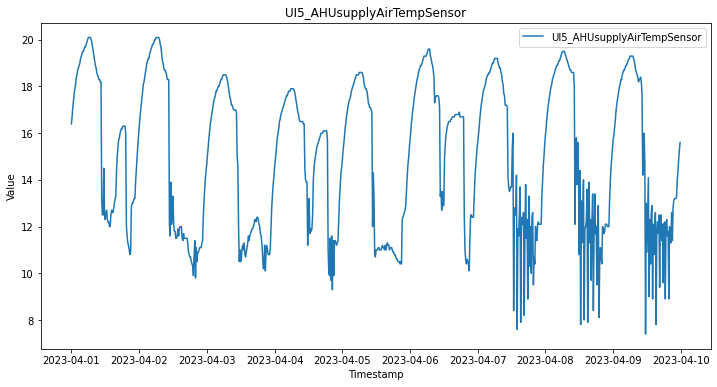

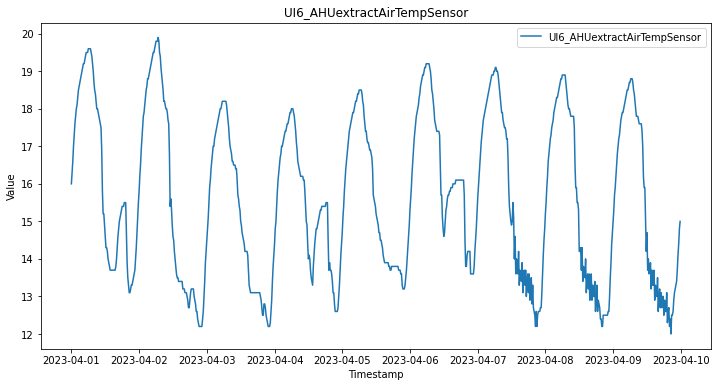

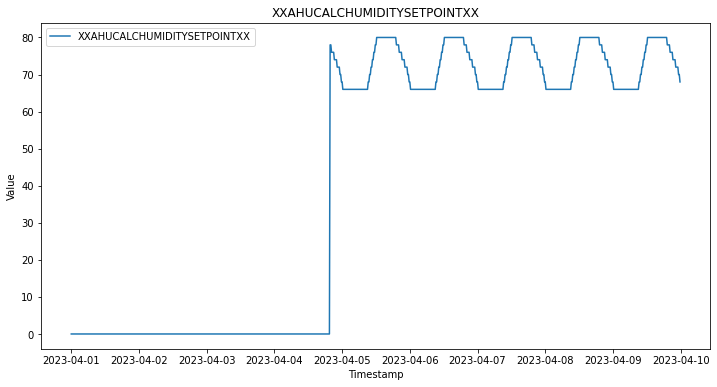

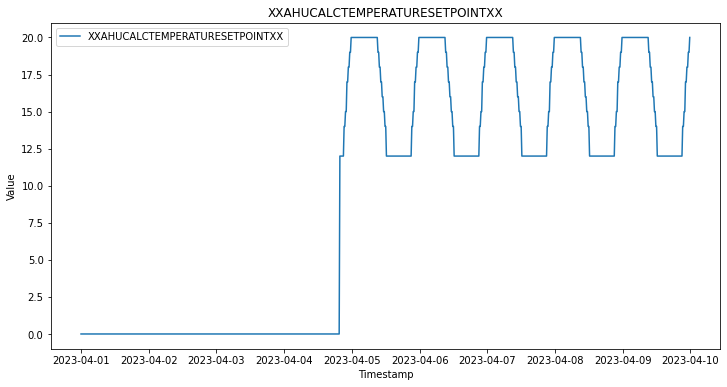

In [12]:
# Plot data over the whole time period

for i in range(rawdata.shape[1]):
    plt.figure(figsize=(12, 6))
    plt.plot(rawdata['Timestamp'], rawdata.iloc[:,i], label=column_names_list[i])
    plt.xlabel('Timestamp')
    plt.ylabel('Value')
    plt.title(column_names_list[i])
    plt.legend()
    plt.show()

## Preprocessing

In [13]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.externals import joblib

data_reducedcols = rawdata.iloc[:, 1:-2]

# Standardize the dataset
scaler = MinMaxScaler()

# Scale the data
scaled_data = scaler.fit_transform(data_reducedcols)

# Save the scaler object
joblib.dump(scaler, root_path + '/scaler.pkl')



/home/dg321/anaconda3/envs/icdss/lib/python3.8/site-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)


['/home/dg321/gitTest/PRI/irp/Ventilation/24-01/scaler.pkl']

In [14]:
# Choose the first 80% samples as training data
train_samples = int(len(scaled_data) * 0.8)
data_train = scaled_data[:train_samples]
data_test = scaled_data[train_samples:]

train_samples_2 = int(len(data_train) * 0.9)
data_val = data_train[train_samples_2:]
train_data = data_train[:train_samples_2]

In [15]:
print("Training Set Shape:", data_train.shape)
print("Validation Set Shape:", data_val.shape)
print("Test Set Shape:", data_test.shape)


Training Set Shape: (690, 10)
Validation Set Shape: (69, 10)
Test Set Shape: (173, 10)


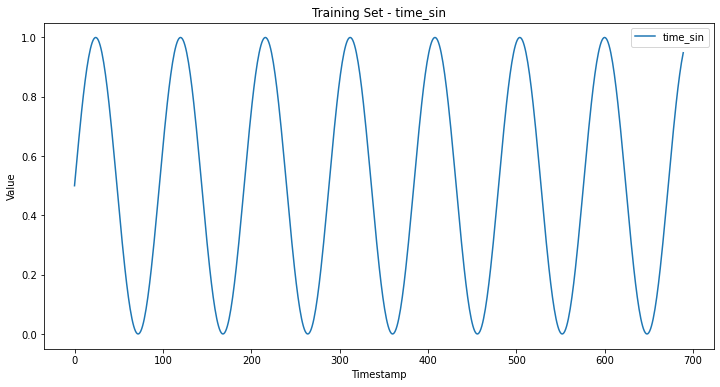

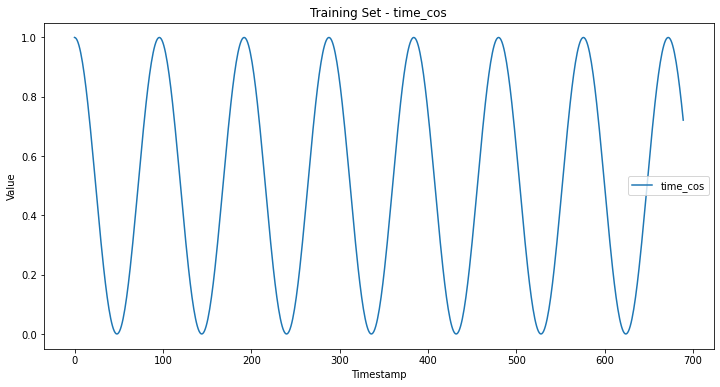

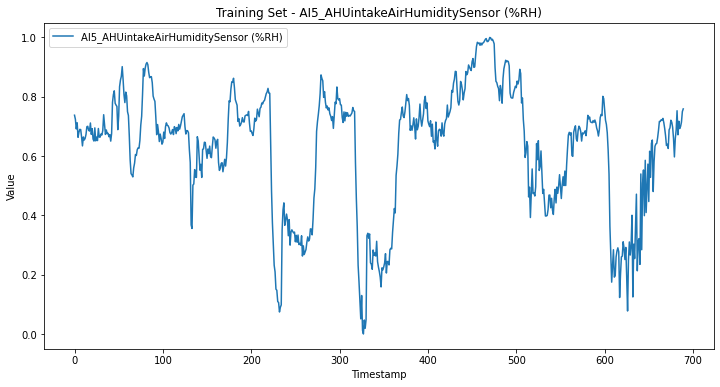

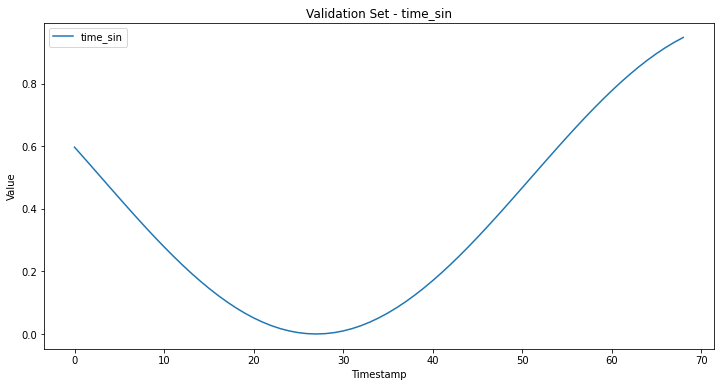

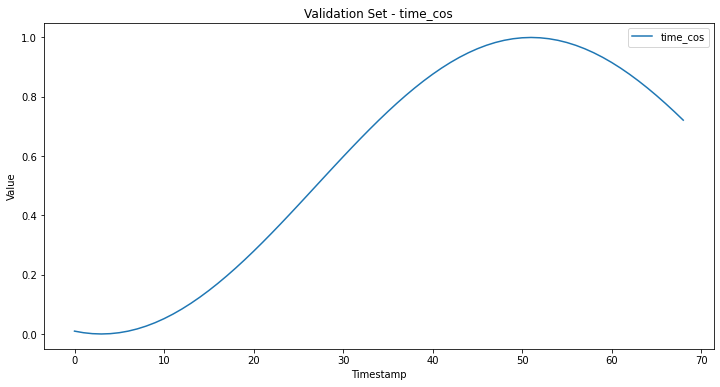

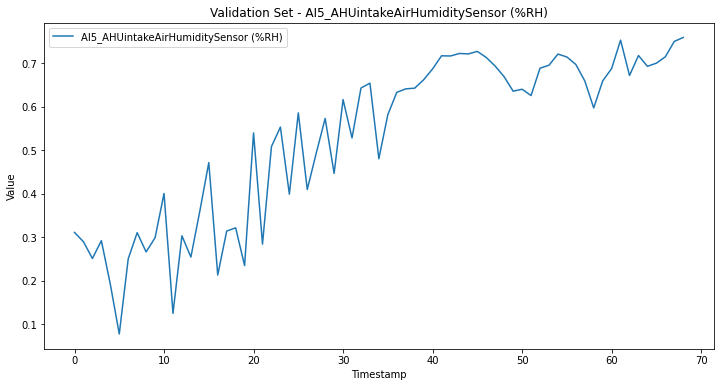

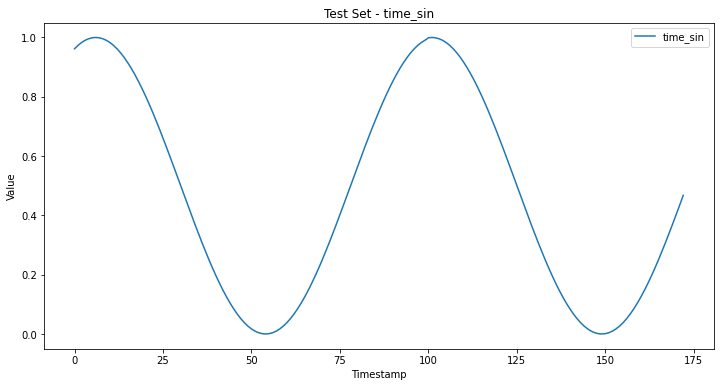

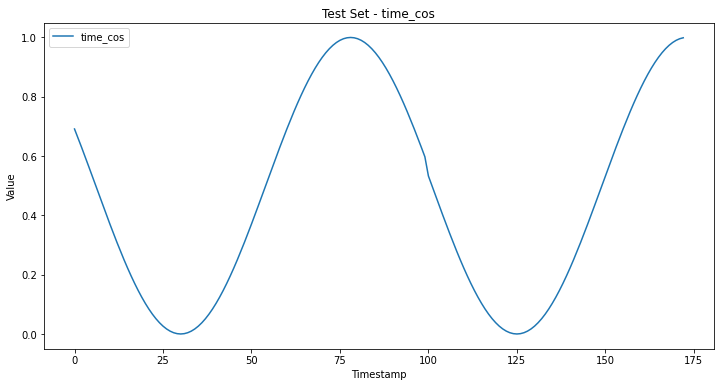

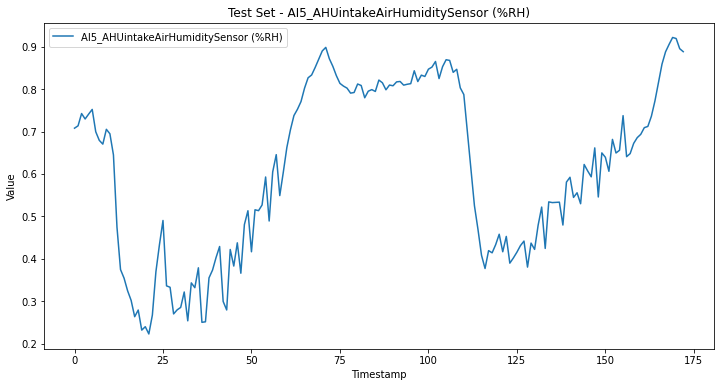

In [16]:
# Plot the first 3 columns for the training set
for i in range(3):
    plt.figure(figsize=(12, 6))
    plt.plot(data_train[:, i], label=column_names_list[i+1])
    plt.xlabel('Timestamp')
    plt.ylabel('Value')
    plt.title(f'Training Set - {column_names_list[i+1]}')
    plt.legend()
    plt.show()

# Plot the first 3 columns for the validation set
for i in range(3):
    plt.figure(figsize=(12, 6))
    plt.plot(data_val[:, i], label=column_names_list[i+1])
    plt.xlabel('Timestamp')
    plt.ylabel('Value')
    plt.title(f'Validation Set - {column_names_list[i+1]}')
    plt.legend()
    plt.show()

# Plot the first 3 columns for the test set
for i in range(3):
    plt.figure(figsize=(12, 6))
    plt.plot(data_test[:, i], label=column_names_list[i+1])
    plt.xlabel('Timestamp')
    plt.ylabel('Value')
    plt.title(f'Test Set - {column_names_list[i+1]}')
    plt.legend()
    plt.show()


## Create dataset and dataloader

In [17]:
all_values = data_train
ncoeffs = data_train.shape[1]
print(ncoeffs)
ntimes = 8
BATCH_SIZE = 32
step = 1

10


In [18]:
train_ct = t.concat_timesteps(all_values, ntimes, step)
val_ct = t.concat_timesteps(data_val, ntimes, step)
test_ct = t.concat_timesteps(data_test, ntimes, step)

In [19]:
print("Type of train_ct: ", type(train_ct))
print("Shape of train_ct: ", train_ct.shape)

Type of train_ct:  <class 'numpy.ndarray'>
Shape of train_ct:  (682, 8, 10)


In [20]:
from torch.utils.data import TensorDataset, DataLoader
import torch

# create dataset
# Convert numpy arrays to PyTorch tensors
train_ct_torch = torch.from_numpy(train_ct).float()
val_ct_torch = torch.from_numpy(val_ct).float()

# Create TensorDatasets
train_dataset = TensorDataset(train_ct_torch)
val_dataset = TensorDataset(val_ct_torch)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

/home/dg321/.local/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


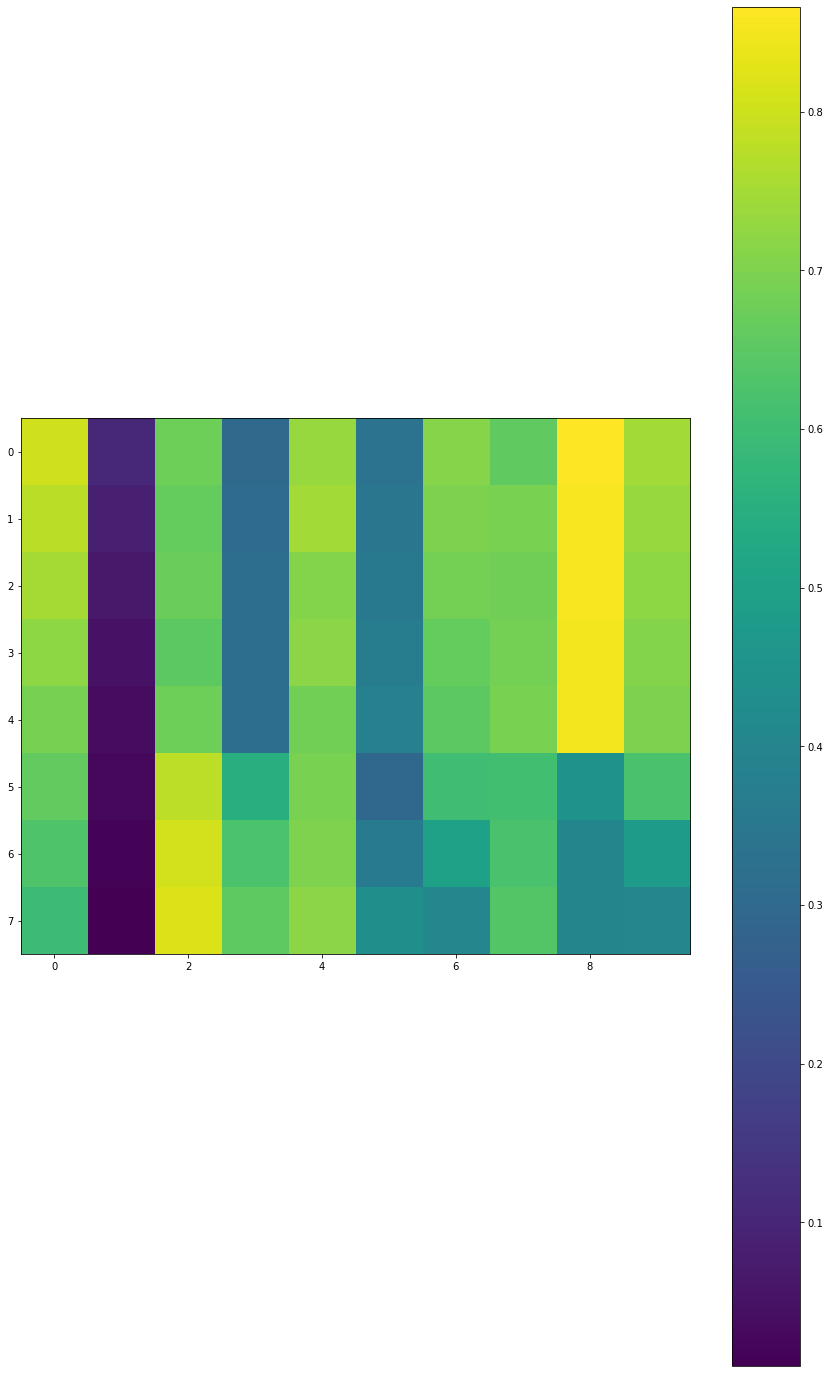

In [21]:
plt.figure(figsize=(15,25))
# Call next() function and get the first element of the tuple
img = next(iter(train_loader))[0][0,:,:]
plt.imshow(img)
plt.colorbar()

## Build network

In [37]:
import torch
from torch import nn
import torch.optim as optim

latent_dim = 20

class Encoder(nn.Module):
    def __init__(self, ntimes, ncoeffs, latent_dim):
        super(Encoder, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(1, 128, (3, 3), stride=(1, 1), padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(),
            nn.Dropout(0.2)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(128, 64, (3, 3), stride=(1, 1), padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(),
            nn.Dropout(0.2)
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(64, 32, (3, 3), stride=(1, 1), padding=1),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(),
            nn.Dropout(0.2)
        )
        self.flatten = nn.Flatten()
        self.fc = nn.Linear(ntimes*ncoeffs*32, latent_dim)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.flatten(x)
        x = self.fc(x)
        return x

class Decoder(nn.Module):
    def __init__(self, ntimes, ncoeffs, latent_dim):
        super(Decoder, self).__init__()
        self.fc = nn.Linear(latent_dim, ntimes*ncoeffs*32)
        self.conv1 = nn.Sequential(
            nn.ConvTranspose2d(32, 64, (3, 3), stride=(1, 1), padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU()
        )
        self.conv2 = nn.Sequential(
            nn.ConvTranspose2d(64, 128, (3, 3), stride=(1, 1), padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU()
        )
        self.conv3 = nn.Sequential(
            nn.ConvTranspose2d(128, 1, (3, 3), stride=(1, 1), padding=1),
            nn.Identity()
        )

    def forward(self, x):
        x = self.fc(x)
        x = x.view(x.shape[0], 32, ntimes, ncoeffs)
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        return x

class Discriminator(nn.Module):
    def __init__(self, latent_dim):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(latent_dim, 240),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(240, 120),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(120, 60),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)

# Adversarial Autoencoder (AAE)
class AdversarialAutoencoder(nn.Module):
    def __init__(self, encoder, decoder, discriminator):
        super(AdversarialAutoencoder, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.discriminator = discriminator

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        discriminated = self.discriminator(encoded)
        return decoded, discriminated

## Train model

In [93]:
# Instantiate components and move to GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

encoder = Encoder(ntimes, ncoeffs, latent_dim).to(device)
decoder = Decoder(ntimes, ncoeffs, latent_dim).to(device)
discriminator = Discriminator(latent_dim = latent_dim).to(device)
aae_model = AdversarialAutoencoder(encoder, decoder, discriminator).to(device)



In [40]:
# Loss functions
reconstruction_loss_fn = nn.MSELoss()
adversarial_loss_fn = nn.BCELoss()

# Optimizers
lr_ae = 0.001
lr_d = 0.001
lr_ed = 0.005

optimizer_ae = optim.Adam(list(encoder.parameters()) + list(decoder.parameters()), lr=lr_ae)
optimizer_d = optim.Adam(discriminator.parameters(), lr=lr_d)
optimizer_ed = optim.Adam(encoder.parameters(), lr=lr_ed)

In [94]:
from torchsummary import summary

# Print the network structure and number of parameters
print("Encoder:")
print(encoder)
summary(encoder, input_size=(1, ntimes, ncoeffs))

print("\nDecoder:")
print(decoder)
summary(decoder, input_size=(1, latent_dim))

print("\nDiscriminator:")
print(discriminator)
summary(discriminator, input_size=(1, latent_dim))

print("\nAdversarial Autoencoder:")
print(aae_model)
summary(aae_model, input_size=(1, ntimes, ncoeffs))

Encoder:
Encoder(
  (conv1): Sequential(
    (0): Conv2d(1, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01)
    (3): Dropout(p=0.2, inplace=False)
  )
  (conv2): Sequential(
    (0): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01)
    (3): Dropout(p=0.2, inplace=False)
  )
  (conv3): Sequential(
    (0): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01)
    (3): Dropout(p=0.2, inplace=False)
  )
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc): Linear(in_features=2560, out_features=20, bias=True)
)
-------------------------------------------------------------

Running on GPU: GeForce RTX 2080 Ti
Epoch [1/300], AE Loss: 1.2339, D Loss: 23.2396, ED Loss: 0.1200, Val AE Loss: 0.1528
Epoch [2/300], AE Loss: 0.1081, D Loss: 5.1292, ED Loss: 0.0252, Val AE Loss: 0.0604
Epoch [3/300], AE Loss: 0.0713, D Loss: 1.4820, ED Loss: 0.3117, Val AE Loss: 0.0494
Epoch [4/300], AE Loss: 0.0601, D Loss: 0.7144, ED Loss: 0.6849, Val AE Loss: 0.0447
Epoch [5/300], AE Loss: 0.0543, D Loss: 0.7011, ED Loss: 0.6931, Val AE Loss: 0.0442
Epoch [6/300], AE Loss: 0.0499, D Loss: 0.6975, ED Loss: 0.6928, Val AE Loss: 0.0398
Epoch [7/300], AE Loss: 0.0451, D Loss: 0.7026, ED Loss: 0.6878, Val AE Loss: 0.0349
Epoch [8/300], AE Loss: 0.0397, D Loss: 0.7018, ED Loss: 0.6879, Val AE Loss: 0.0302
Epoch [9/300], AE Loss: 0.0351, D Loss: 0.6966, ED Loss: 0.6925, Val AE Loss: 0.0246
Epoch [10/300], AE Loss: 0.0301, D Loss: 0.6956, ED Loss: 0.6931, Val AE Loss: 0.0189
Epoch [11/300], AE Loss: 0.0251, D Loss: 0.6950, ED Loss: 0.6922, Val AE Loss: 0.0138
Epoch [12/300], AE Loss: 0

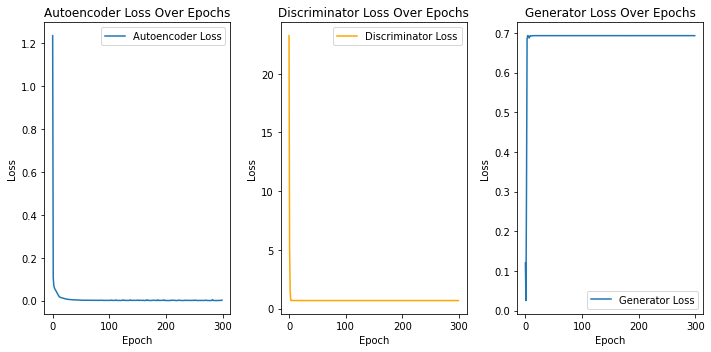

Training finished.
Moved model back to CPU.


In [41]:
# Set the checkpoint directory
checkpoint_dir = root_path + '/checkpoints'
os.makedirs(checkpoint_dir, exist_ok=True)

num_epochs = 300

# Set the checkpoint frequency (save every n epochs)
checkpoint_freq = 50

# Lists to store losses for plotting
all_losses_ae = []
all_losses_d = []
all_losses_ed = []
all_losses_ae_val = []

# Print the GPU device
print(f"Running on GPU: {torch.cuda.get_device_name(torch.cuda.current_device())}")
# Training loop
for epoch in range(num_epochs):
    epoch_losses_ae = []
    epoch_losses_d = []
    epoch_losses_ed = []

    for batch in train_loader:
        inputs = batch[0].to(device).unsqueeze(1)
        targets = inputs  # Autoencoder: input = target

        # print(inputs.shape)

        # Train autoencoder/predictor
        optimizer_ae.zero_grad()
        decoded, discriminated = aae_model(inputs)
        loss_ae = reconstruction_loss_fn(decoded, targets)
        loss_ae.backward()
        optimizer_ae.step()
        epoch_losses_ae.append(loss_ae.item())

        # Train encoder/generator
        optimizer_ed.zero_grad()
        with torch.no_grad():
            encoded_fool = encoder(inputs).detach()
        fake_output = discriminator(encoded_fool)
        loss_ed = adversarial_loss_fn(fake_output, torch.ones_like(fake_output).to(device))
        loss_ed.backward()
        optimizer_ed.step()
        epoch_losses_ed.append(loss_ed.item())

        # Train discriminator
        optimizer_d.zero_grad()
        with torch.no_grad():
            encoded_fake = encoder(inputs).detach()
            encoded_true = torch.randn_like(encoded_fake).to(device)   # the true sample
        fake_output = discriminator(encoded_fake)
        true_output = discriminator(encoded_true)
        loss_d = adversarial_loss_fn(fake_output, torch.zeros_like(fake_output).to(device)) + \
                 adversarial_loss_fn(true_output, torch.ones_like(true_output).to(device))
        loss_d.backward()
        optimizer_d.step()
        epoch_losses_d.append(loss_d.item())
    
    # Validation phase
    with torch.no_grad():
        for val_batch in val_loader:  
            val_inputs = val_batch[0].to(device).unsqueeze(1)
            val_targets = val_inputs  # Autoencoder: input = target
            val_decoded, val_discriminated = aae_model(val_inputs)

            val_loss_ae = reconstruction_loss_fn(val_decoded, val_targets).item()

            # Record validation losses
            all_losses_ae_val.append(val_loss_ae)

    # Average losses over the epoch
    avg_loss_ae = sum(epoch_losses_ae) / len(epoch_losses_ae)
    avg_loss_d = sum(epoch_losses_d) / len(epoch_losses_d)
    avg_loss_ed = sum(epoch_losses_ed) / len(epoch_losses_ed)
    avg_loss_ed_val = sum(all_losses_ae_val) / len(all_losses_ae_val)

    # Print the average loss at the end of each epoch
    print(f'Epoch [{epoch+1}/{num_epochs}], AE Loss: {avg_loss_ae:.4f}, D Loss: {avg_loss_d:.4f}, ED Loss: {avg_loss_ed:.4f}, Val AE Loss: {val_loss_ae:.4f}')

    # Record the losses for plotting
    all_losses_ae.append(avg_loss_ae)
    all_losses_d.append(avg_loss_d)
    all_losses_ed.append(avg_loss_ed)

    # Save checkpoint
    if (epoch + 1) % checkpoint_freq == 0:
        checkpoint_path = os.path.join(checkpoint_dir, f'checkpoint_epoch_{epoch + 1 + check_epochs}.pth')
        print(checkpoint_path)
        torch.save({
            'epoch': epoch + 1,
            'model_state_dict': aae_model.state_dict(),
            'optimizer_ae_state_dict': optimizer_ae.state_dict(),
            'optimizer_d_state_dict': optimizer_d.state_dict(),
            'optimizer_ed_state_dict': optimizer_ed.state_dict(),
            'all_losses_ae': all_losses_ae,
            'all_losses_d': all_losses_d,
            'all_losses_ed': all_losses_ed,
            'all_losses_ae_val': all_losses_ae_val,
        }, checkpoint_path)
        print(f'Checkpoint saved at epoch {epoch + 1}.')

# Plot the losses separately
plt.figure(figsize=(10, 5))

# Autoencoder Loss Plot
plt.subplot(1, 3, 1)
plt.plot(all_losses_ae, label='Autoencoder Loss')
plt.title('Autoencoder Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Discriminator Loss Plot
plt.subplot(1, 3, 2)
plt.plot(all_losses_d, label='Discriminator Loss', color='orange')
plt.title('Discriminator Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# ED Loss Plot
plt.subplot(1, 3, 3)
plt.plot(all_losses_ed, label='Generator Loss')
plt.title('Generator Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

print("Training finished.")
aae_model = aae_model.cpu()
print("Moved model back to CPU.")

## Load saved model

In [64]:
check_epochs = 250
checkpoint = torch.load(root_path + '/checkpoints/checkpoint_epoch_{}.pth'.format(check_epochs))

In [65]:
# Instantiate components and move to GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load the saved autoencoder
# encoder = Encoder(ntimes, ncoeffs, latent_dim).to(device)
# decoder = Decoder(ntimes, ncoeffs, latent_dim).to(device)
# discriminator = Discriminator(latent_dim = latent_dim).to(device)
# aae_model = AdversarialAutoencoder(encoder, decoder, discriminator).to(device)

encoder = Encoder(ntimes, ncoeffs, latent_dim)
decoder = Decoder(ntimes, ncoeffs, latent_dim)
discriminator = Discriminator(latent_dim = latent_dim)
aae_model = AdversarialAutoencoder(encoder, decoder, discriminator)


aae_model.load_state_dict(checkpoint['model_state_dict'])

aae_model.eval()  # Set the autoencoder to evaluation mode

AdversarialAutoencoder(
  (encoder): Encoder(
    (conv1): Sequential(
      (0): Conv2d(1, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.01)
      (3): Dropout(p=0.2, inplace=False)
    )
    (conv2): Sequential(
      (0): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.01)
      (3): Dropout(p=0.2, inplace=False)
    )
    (conv3): Sequential(
      (0): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.01)
      (3): Dropout(p=0.2, inplace=False)
    )
    (flatten): Flatten(start_dim=1, end_dim=-1)
    (fc): Linear(in_features=2560, out_features=20, bias=T

## Predict

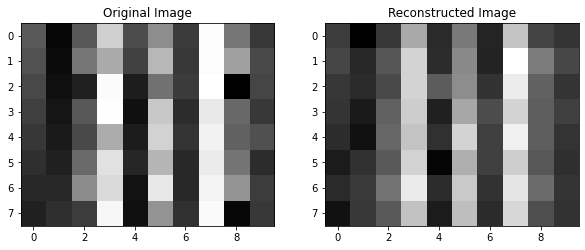

In [70]:
# Set the model to evaluation mode
aae_model.eval()

predict_loader = train_loader
data_ground = data_train
n = 500

# Select a sample from your dataset
sample = next(iter(train_loader))[0].unsqueeze(1)

# Predict using the model
with torch.no_grad():
    decoded, _ = aae_model(sample)

# Move the prediction to cpu and convert to numpy
decoded = decoded.cpu().numpy()

# Plot the original and reconstructed images
plt.figure(figsize=(10, 4))

# Original image
plt.subplot(1, 2, 1)
plt.imshow(sample.cpu().numpy()[0, 0, :, :], cmap='gray')
plt.title('Original Image')

# Reconstructed image
plt.subplot(1, 2, 2)
plt.imshow(decoded[0, 0, :, :], cmap='gray')
plt.title('Reconstructed Image')

plt.show()

In [71]:
# Set the model to evaluation mode
aae_model.eval()

# Select a sample from your dataset
sample = next(iter(predict_loader))[0].unsqueeze(1)[:1]
# Initialize the hidden state
hidden = None

# List to store the predictions
predictions = []
ground_truth = []

# Predict using the model
with torch.no_grad():
    decoded, hidden = aae_model(sample)

# Store the prediction
predictions.append(decoded[:,:,-1:,:])

# Predict the next n time steps
for i in range(n):
    # Use the last prediction as input
    sample_new = torch.cat((sample[:,:,1:8,:], predictions[-1]), dim=2)
    

    # Predict using the model
    with torch.no_grad():
        decoded, hidden = aae_model(sample_new)

    # Store the prediction
    predictions.append(decoded[:,:,-1:,:])

    sample = sample_new

# Convert the list of predictions to a tensor
predictions = torch.stack(predictions, dim=2).view(-1, ncoeffs)

# Move the prediction to cpu and convert to numpy
predictions = predictions.cpu().numpy()

print(predictions.shape)

plt.show()

(501, 10)


In [72]:
start_index = 7
ground_truth = data_ground[start_index:start_index+predictions.shape[0], :]
print(ground_truth.shape) 

(501, 10)


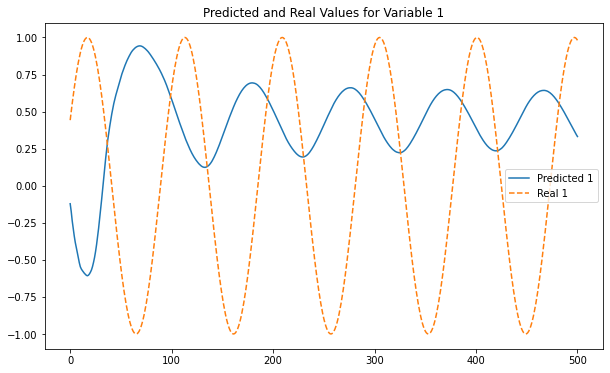

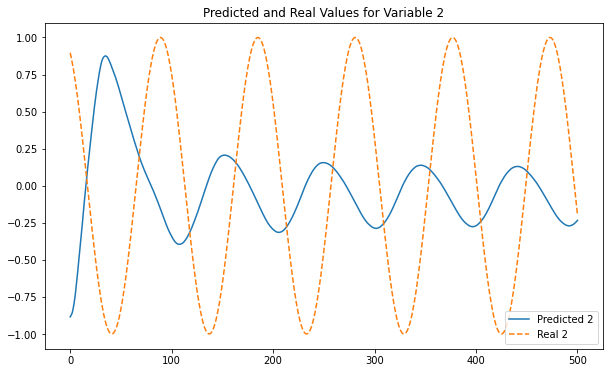

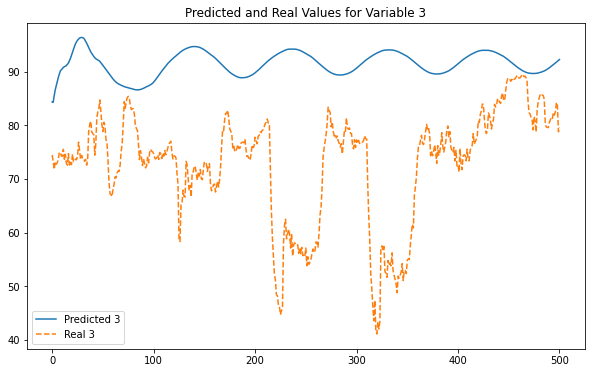

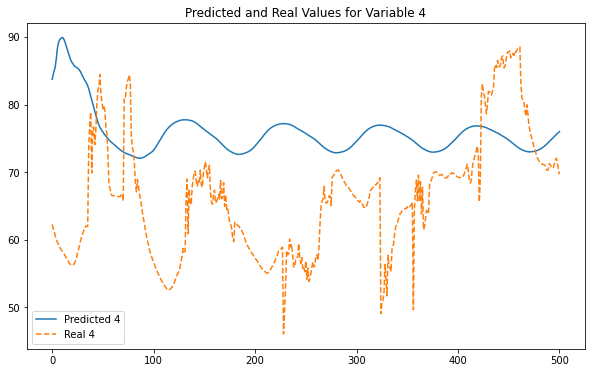

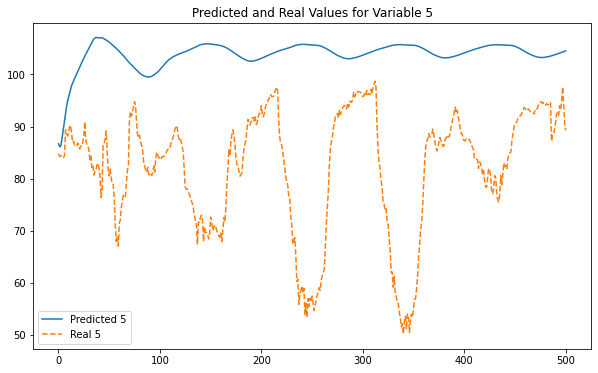

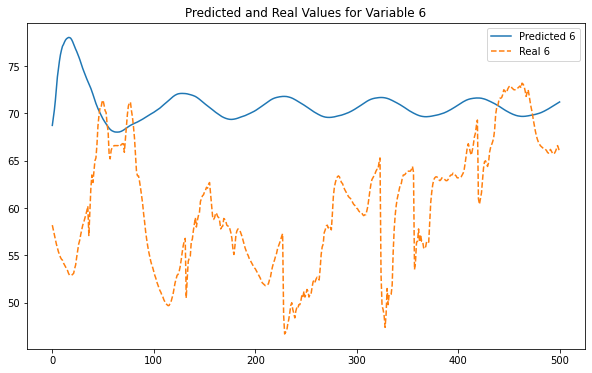

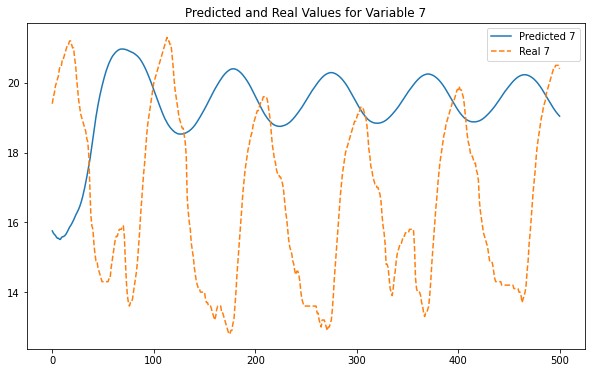

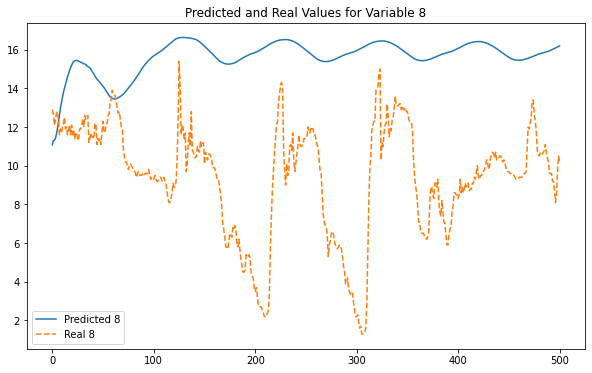

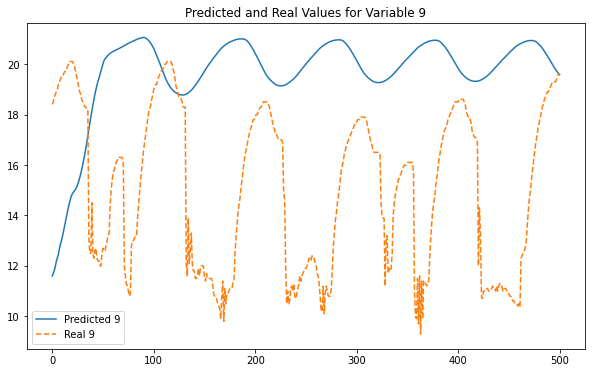

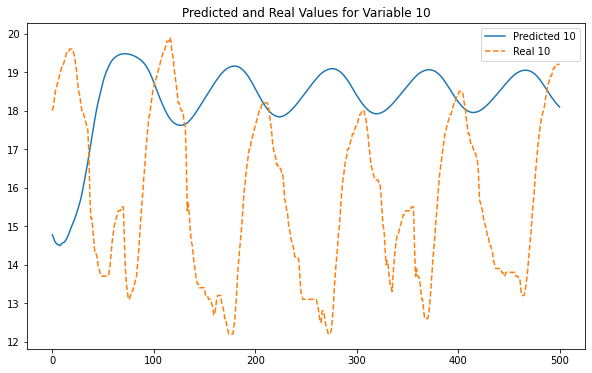

In [73]:
predictions_inverse = scaler.inverse_transform(predictions)
real_values_inverse = scaler.inverse_transform(ground_truth)

for i in range(predictions_inverse.shape[1]):
    plt.figure(figsize=(10, 6))
    plt.plot(predictions_inverse[:, i], label=f'Predicted {i+1}')
    plt.plot(real_values_inverse[:, i], label=f'Real {i+1}', linestyle='--')
    plt.title(f'Predicted and Real Values for Variable {i+1}')
    plt.legend()
    plt.show()

## LSTM

In [38]:
import torch
import torch.nn as nn
import torch.optim as optim

In [31]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [135]:
from copy import deepcopy as dc

end_index = 10

train_ct_fliped = dc(np.flip(train_ct[:,:7, :end_index], axis=1))
test_ct_fliped = dc(np.flip(test_ct[:,:7, :end_index], axis=1))


In [136]:
X_train = torch.tensor(train_ct_fliped).float()
y_train = torch.tensor(train_ct[:,7:, :end_index]).float().squeeze(1)
X_test = torch.tensor(test_ct_fliped).float()
y_test = torch.tensor(test_ct[:,7:, :end_index]).float().squeeze(1)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

(torch.Size([682, 7, 10]),
 torch.Size([165, 7, 10]),
 torch.Size([682, 10]),
 torch.Size([165, 10]))

In [137]:
from torch.utils.data import Dataset

class TimeSeriesDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, i):
        return self.X[i], self.y[i]
    
train_dataset = TimeSeriesDataset(X_train, y_train)
test_dataset = TimeSeriesDataset(X_test, y_test)

In [138]:
batch_size = 16

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [139]:
for _, batch in enumerate(train_loader):
    x_batch, y_batch = batch[0].to(device), batch[1].to(device)
    print(x_batch.shape, y_batch.shape)
    break

torch.Size([16, 7, 10]) torch.Size([16, 10])


In [149]:
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_stacked_layers):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_stacked_layers = num_stacked_layers

        self.lstm = nn.LSTM(input_size, hidden_size, num_stacked_layers, 
                            batch_first=True)
        
        self.fc = nn.Linear(hidden_size, 10)

    def forward(self, x):
        batch_size = x.size(0)
        h0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size).to(device)
        c0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size).to(device)
        
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

model = LSTM(10, 4, 1)
model.to(device)
model


LSTM(
  (lstm): LSTM(10, 4, batch_first=True)
  (fc): Linear(in_features=4, out_features=10, bias=True)
)

In [150]:
def train_one_epoch():
    model.train(True)
    print(f'Epoch: {epoch + 1}')
    running_loss = 0.0
    
    for batch_index, batch in enumerate(train_loader):
        x_batch, y_batch = batch[0].to(device), batch[1].to(device)
        # print(x_batch.shape)
        # print(y_batch.shape)
        
        output = model(x_batch)
        # print(output.shape)
        
        
        loss = loss_function(output, y_batch)
        running_loss += loss.item()
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch_index % 100 == 99:  # print every 100 batches
            avg_loss_across_batches = running_loss / 100
            print('Batch {0}, Loss: {1:.3f}'.format(batch_index+1,
                                                    avg_loss_across_batches))
            running_loss = 0.0
    print()

In [151]:
def validate_one_epoch():
    model.train(False)
    running_loss = 0.0
    
    for batch_index, batch in enumerate(test_loader):
        x_batch, y_batch = batch[0].to(device), batch[1].to(device)
        
        with torch.no_grad():
            output = model(x_batch)
            loss = loss_function(output, y_batch)
            running_loss += loss.item()

    avg_loss_across_batches = running_loss / len(test_loader)
    
    print('Val Loss: {0:.3f}'.format(avg_loss_across_batches))
    print('***************************************************')
    print()

In [155]:
learning_rate = 0.001
num_epochs = 100
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

for epoch in range(num_epochs):
    train_one_epoch()
    validate_one_epoch()

Epoch: 1

Val Loss: 0.013
***************************************************

Epoch: 2

Val Loss: 0.013
***************************************************

Epoch: 3

Val Loss: 0.013
***************************************************

Epoch: 4

Val Loss: 0.012
***************************************************

Epoch: 5

Val Loss: 0.013
***************************************************

Epoch: 6

Val Loss: 0.012
***************************************************

Epoch: 7

Val Loss: 0.012
***************************************************

Epoch: 8

Val Loss: 0.012
***************************************************

Epoch: 9

Val Loss: 0.012
***************************************************

Epoch: 10

Val Loss: 0.012
***************************************************

Epoch: 11

Val Loss: 0.012
***************************************************

Epoch: 12

Val Loss: 0.012
***************************************************

Epoch: 13

Val Loss: 0.012
**********************

In [164]:
torch.save(model.state_dict(), root_path + '/lstm/lstm_model_epochs{}.pth'.format(num_epochs))

### Predict

torch.Size([682, 10])
(682, 10)


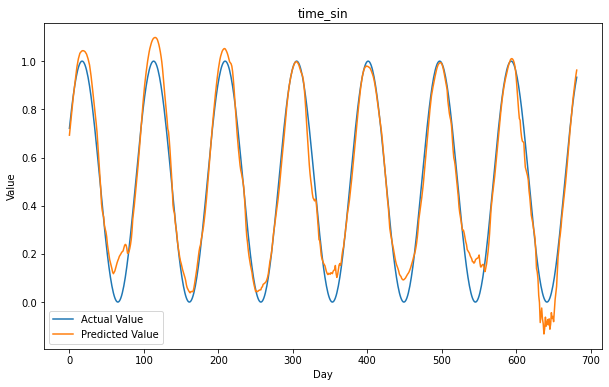

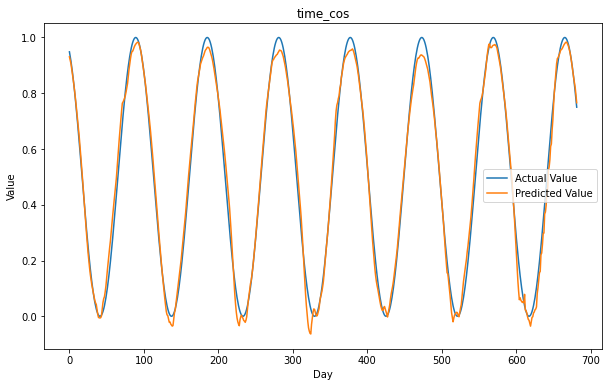

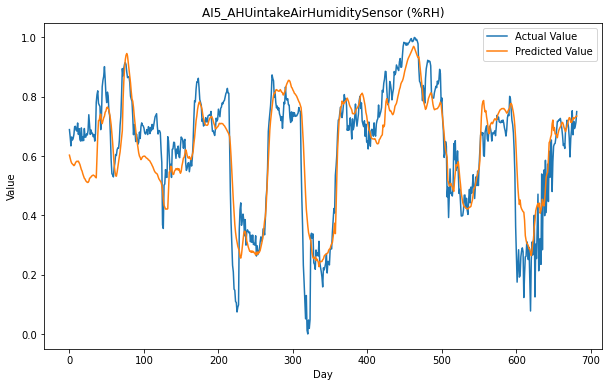

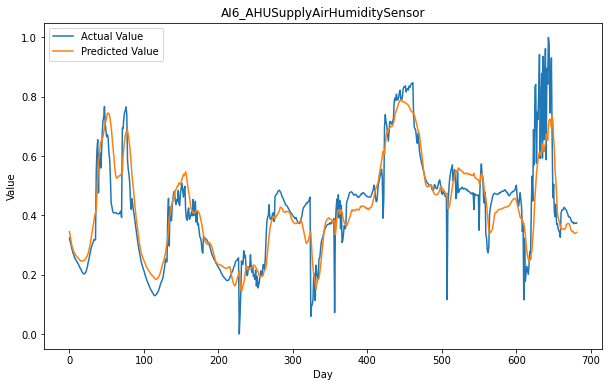

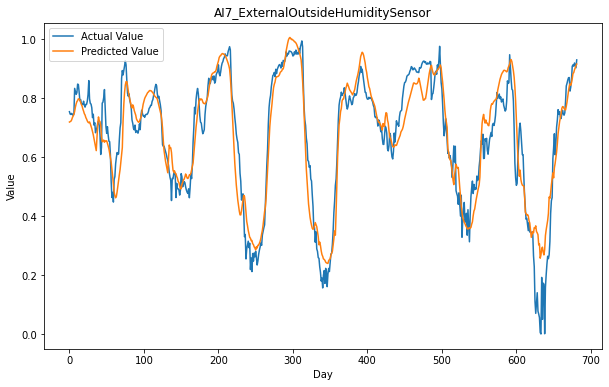

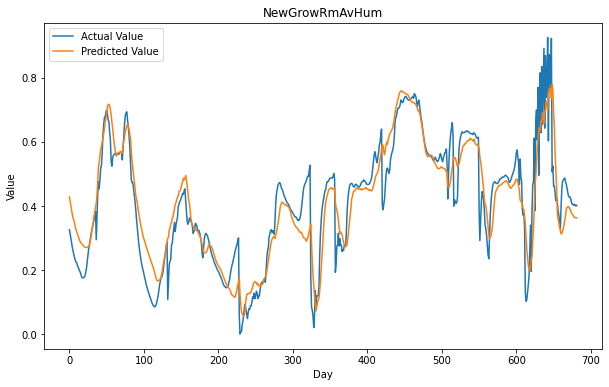

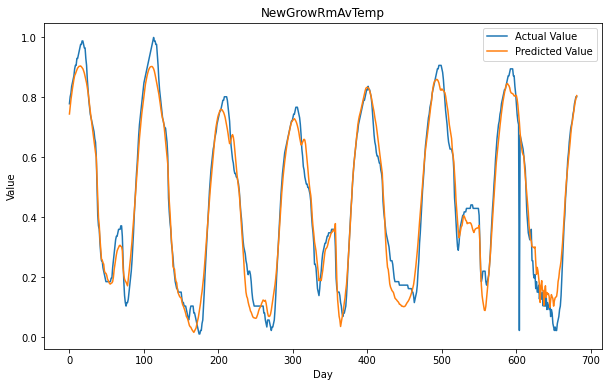

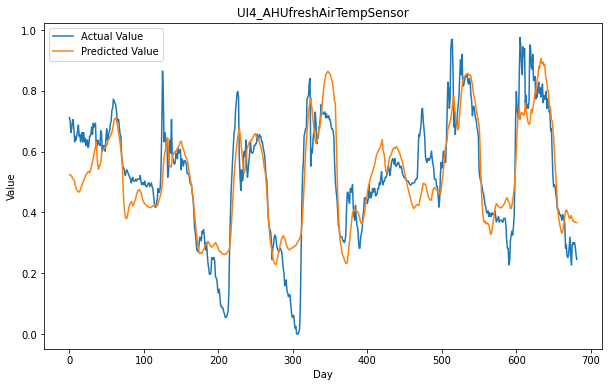

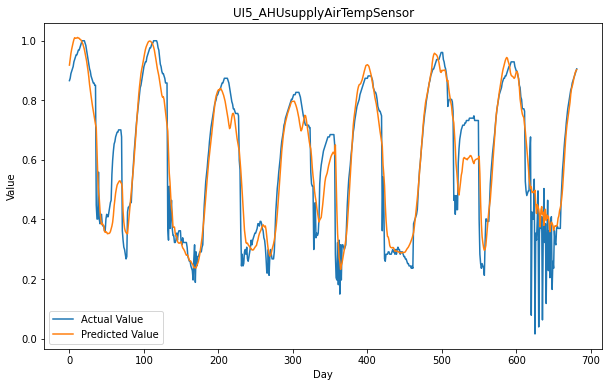

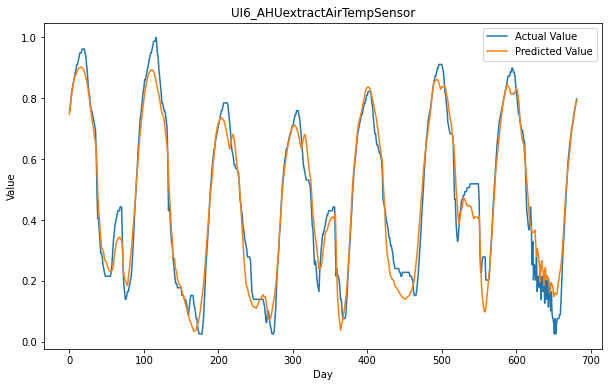

In [159]:
print(y_train.shape)
with torch.no_grad():
    predicted = model(X_train.to(device)).to('cpu').numpy()
    print(predicted.shape)

# Get the number of columns
num_cols = y_train.shape[1]

# Create a plot for each column
for col_index in range(num_cols):
    plt.figure(figsize=(10, 6))
    plt.plot(y_train[:,col_index], label='Actual Value')
    plt.plot(predicted[:,col_index], label='Predicted Value')
    plt.xlabel('Day')
    plt.ylabel('Value')
    plt.title(column_names_list[col_index+1])
    plt.legend()
    plt.show()

torch.Size([682, 10])
(682, 10)


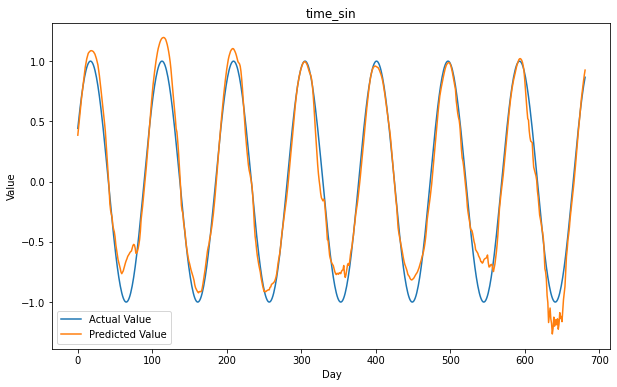

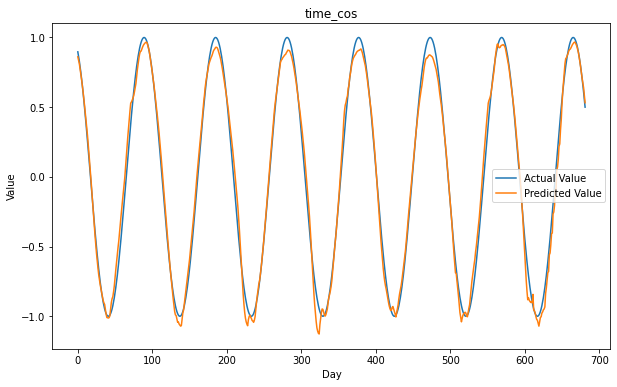

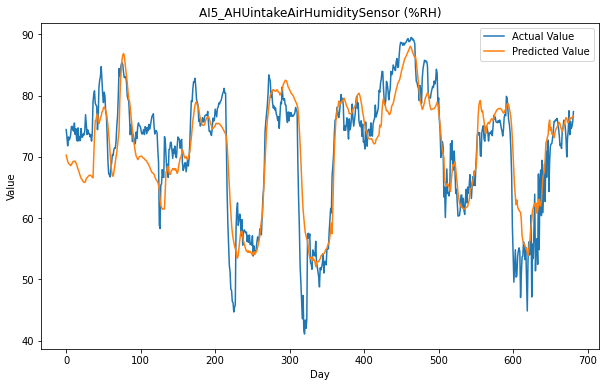

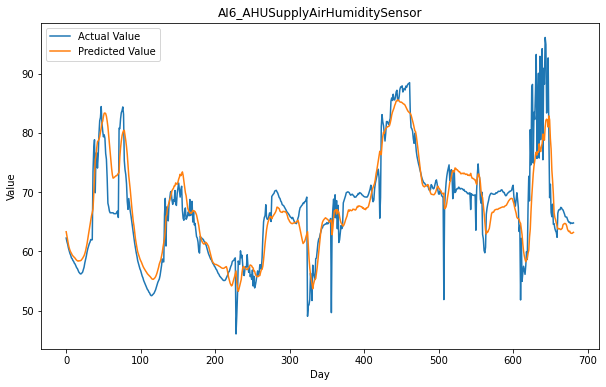

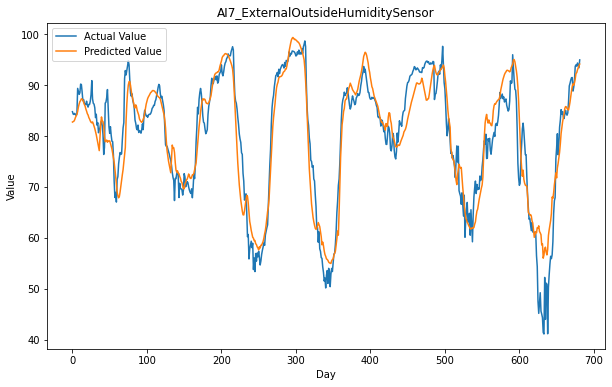

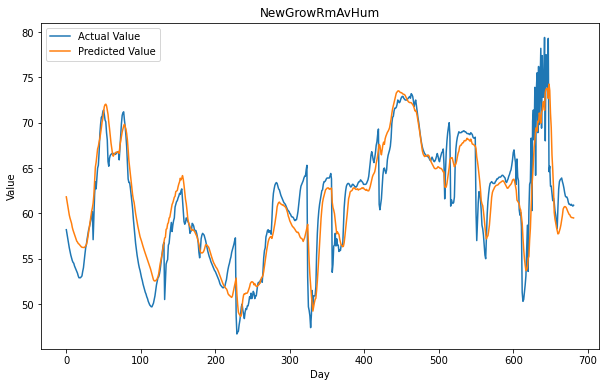

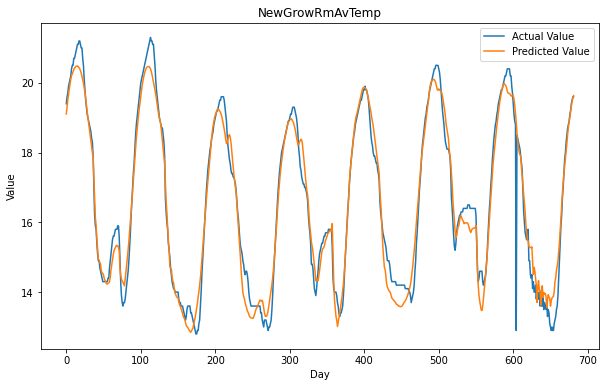

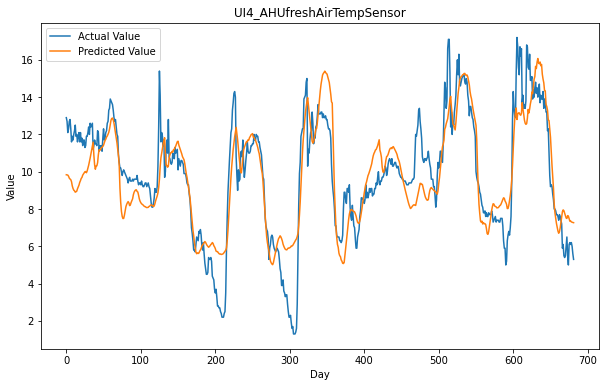

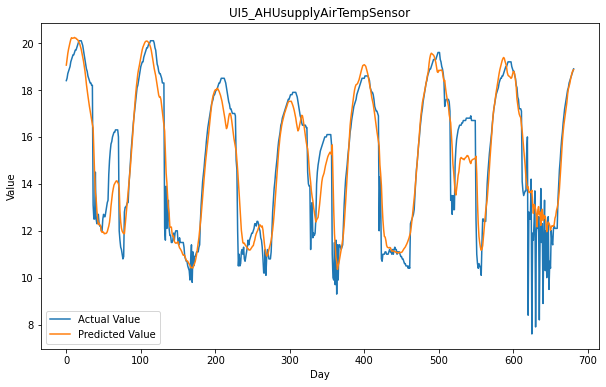

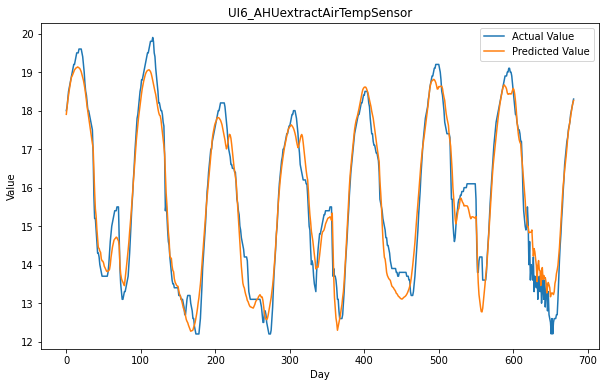

In [162]:
print(y_train.shape)
with torch.no_grad():
    predicted = model(X_train.to(device)).to('cpu').numpy()
    print(predicted.shape)

# Inverse transform the data
y_train_inverse = scaler.inverse_transform(y_train)
predicted_inverse = scaler.inverse_transform(predicted)

# Get the number of columns
num_cols = y_train.shape[1]

# Create a plot for each column
for col_index in range(num_cols):
    plt.figure(figsize=(10, 6))
    plt.plot(y_train_inverse[:,col_index], label='Actual Value')
    plt.plot(predicted_inverse[:,col_index], label='Predicted Value')
    plt.xlabel('Day')
    plt.ylabel('Value')
    plt.title(column_names_list[col_index+1])
    plt.legend()
    plt.show()

torch.Size([165, 10])
(165, 10)


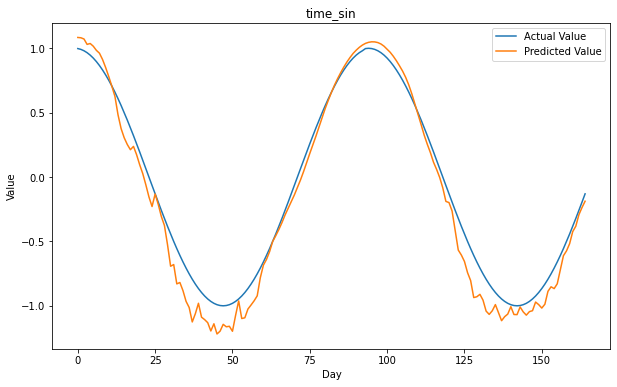

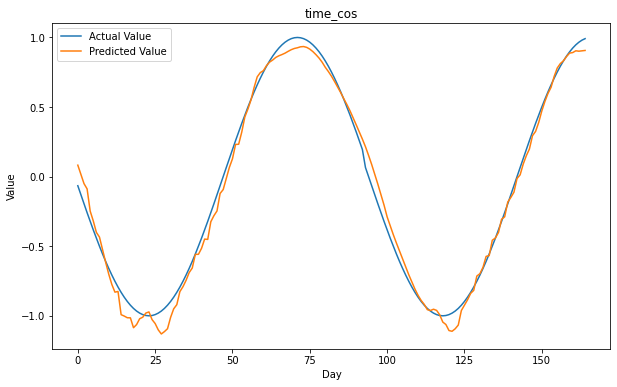

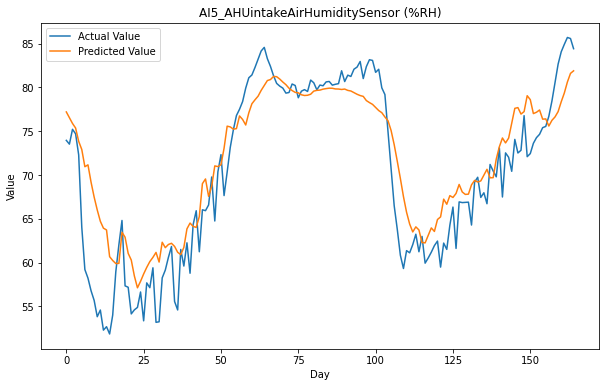

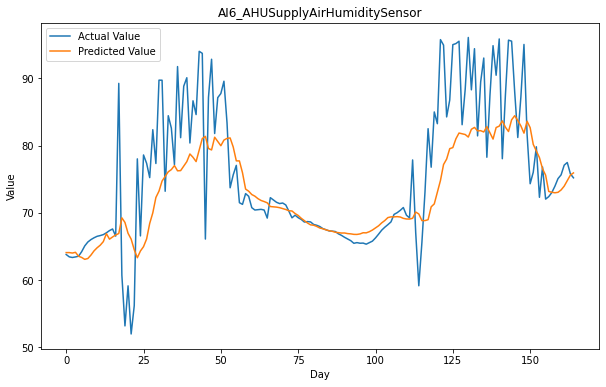

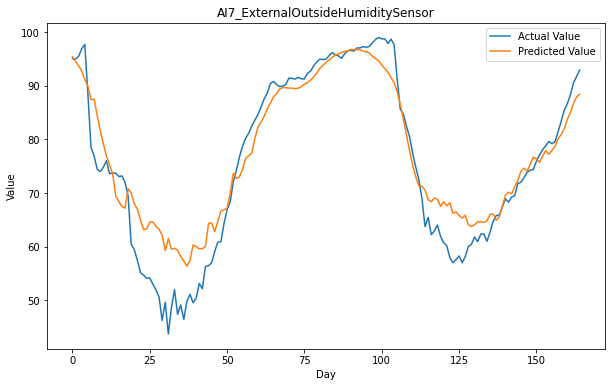

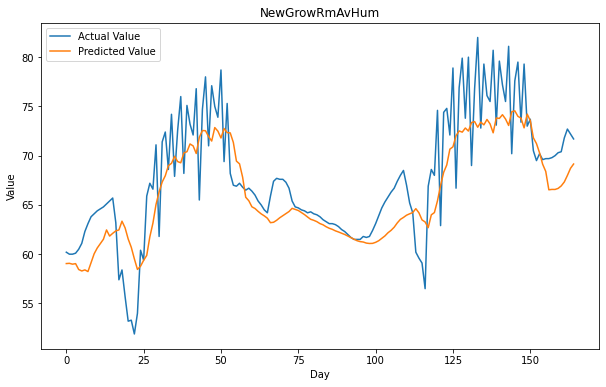

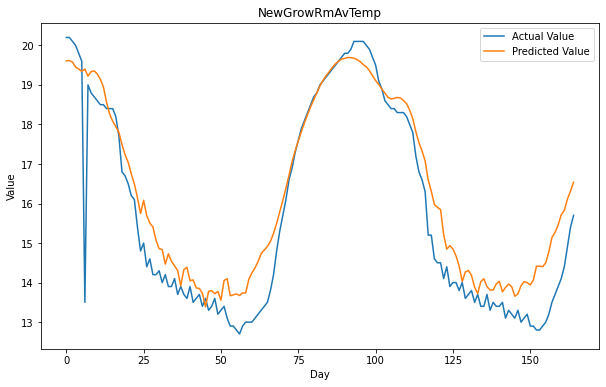

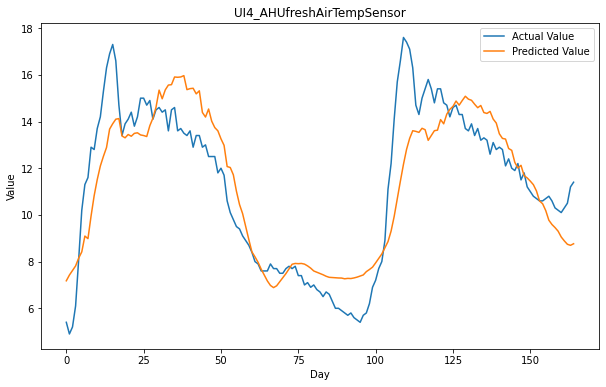

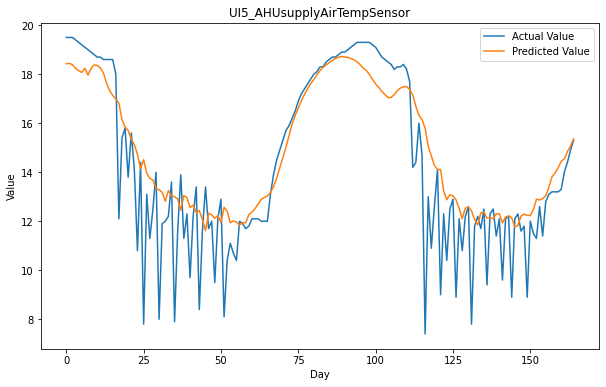

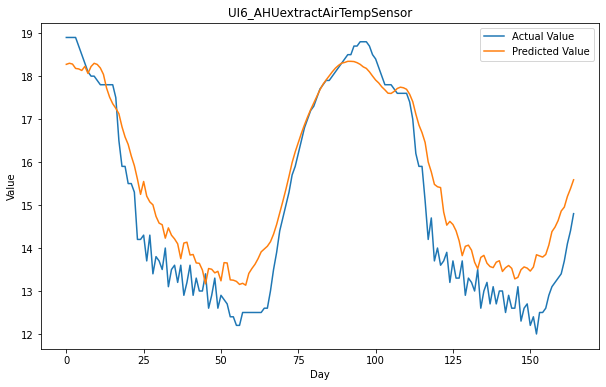

In [165]:
print(y_test.shape)
with torch.no_grad():
    predicted = model(X_test.to(device)).to('cpu').numpy()
    print(predicted.shape)

# Inverse transform the data
y_test_inverse = scaler.inverse_transform(y_test)
predicted_inverse = scaler.inverse_transform(predicted)

# Get the number of columns
num_cols = y_test.shape[1]

# Create a plot for each column
for col_index in range(num_cols):
    plt.figure(figsize=(10, 6))
    plt.plot(y_test_inverse[:,col_index], label='Actual Value')
    plt.plot(predicted_inverse[:,col_index], label='Predicted Value')
    plt.xlabel('Day')
    plt.ylabel('Value')
    plt.title(column_names_list[col_index+1])
    plt.legend()
    plt.show()